[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished


162.957 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


92.931 --> 92.931 --> 

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.0s finished


C:\Users\User\AppData\Local\Temp\ipykernel_7172\1705300254.py:51: RuntimeWarning: Mean of empty slice
  mean_sequence = np.nanmean(np.array(cluster_sequences), axis=0)


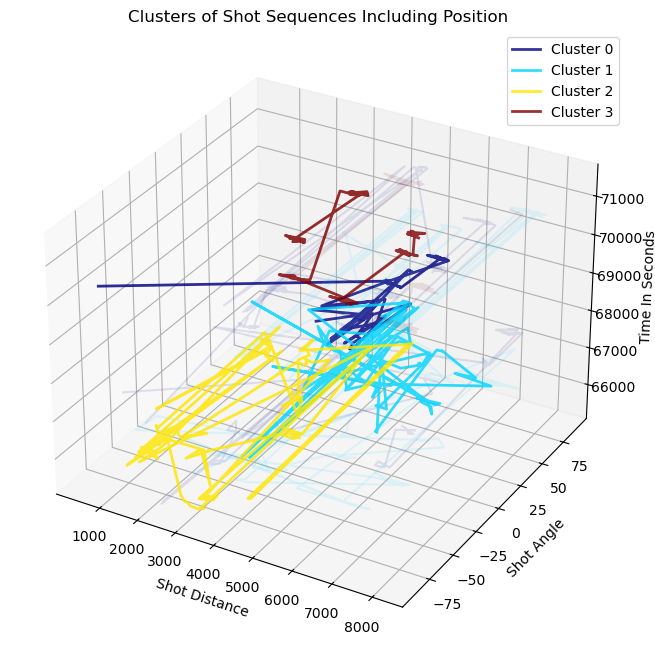

In [25]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# קריאה והכנת הנתונים
df = pd.read_csv('clean_df.csv')
df['TimeInSeconds'] = pd.to_numeric(df['TimeInSeconds'])
df['ShotAngle'] = pd.to_numeric(df['ShotAngle'])
df['ShotDistance'] = pd.to_numeric(df['ShotDistance'])
df['Position'] = pd.to_numeric(df['Position'])

# הנחה: יצירת מזהה רצף (SessionID) כדי להגדיר רצפים ברורים
# יש להוסיף מזהה כזה בדאטה אם אין
df['SessionID'] = (df['TimeInSeconds'].diff() > 30).cumsum()  # חלוקה לפי מרווח זמן מעל 60 שניות כסימן לרצף חדש

# יצירת רצפים לפי SessionID
sequences = []
for session_id in df['SessionID'].unique():
    session_data = df[df['SessionID'] == session_id]
    sequence = session_data[['ShotDistance', 'ShotAngle', 'TimeInSeconds', 'Position']].values
    sequences.append(sequence)

# התאמת אורכי הרצפים
max_length = max(len(seq) for seq in sequences)
for i in range(len(sequences)):
    sequences[i] = np.pad(sequences[i], ((0, max_length - len(sequences[i])), (0, 0)), mode='constant', constant_values=np.nan)

# נרמול הרצפים
scaler = TimeSeriesScalerMeanVariance()
sequences_scaled = scaler.fit_transform(sequences)

# קלאסטרינג על הרצפים עם K-Means ו-DTW
n_clusters = 4  # ניתן לשנות את מספר הקלאסטרים לאחר בדיקות
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=True)
labels = model.fit_predict(sequences_scaled)

# ויזואליזציה של הקלאסטרים בתלת מימד עם צבעים שונים לכל קלאסטר
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.jet(np.linspace(0, 1, n_clusters))
for label, color in zip(set(labels), colors):
    cluster_sequences = [sequences[i] for i in range(len(labels)) if labels[i] == label]
    for seq in cluster_sequences:
        ax.plot(seq[:, 0], seq[:, 1], seq[:, 2], alpha=0.1, color=color)  # מצייר את המרחק מול הזווית והזמן כציר Z

    # הוספת מסלול ממוצע של כל קלאסטר
    mean_sequence = np.nanmean(np.array(cluster_sequences), axis=0)
    ax.plot(mean_sequence[:, 0], mean_sequence[:, 1], mean_sequence[:, 2], alpha=0.8, color=color, linewidth=2, label=f'Cluster {label}')

ax.set_title("Clusters of Shot Sequences Including Position")
ax.set_xlabel("Shot Distance")
ax.set_ylabel("Shot Angle")
ax.set_zlabel("Time In Seconds")
plt.legend()
plt.show()
